In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anakindang","key":"b2ae38f43ac2fda8d789056ac6c940fc"}'}

In [1]:
!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d joosthazelzet/lego-brick-images

100% 1.00G/1.00G [00:33<00:00, 36.1MB/s]
100% 1.00G/1.00G [00:33<00:00, 32.0MB/s]


In [ ]:
!unzip lego-brick-images.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: dataset/43857 beam 1x2 300R.png  
  inflating: dataset/43857 beam 1x2 301L.png  
  inflating: dataset/43857 beam 1x2 301R.png  
  inflating: dataset/43857 beam 1x2 302L.png  
  inflating: dataset/43857 beam 1x2 302R.png  
  inflating: dataset/43857 beam 1x2 303L.png  
  inflating: dataset/43857 beam 1x2 303R.png  
  inflating: dataset/43857 beam 1x2 304L.png  
  inflating: dataset/43857 beam 1x2 304R.png  
  inflating: dataset/43857 beam 1x2 305L.png  
  inflating: dataset/43857 beam 1x2 305R.png  
  inflating: dataset/43857 beam 1x2 306L.png  
  inflating: dataset/43857 beam 1x2 306R.png  
  inflating: dataset/43857 beam 1x2 307L.png  
  inflating: dataset/43857 beam 1x2 307R.png  
  inflating: dataset/43857 beam 1x2 308L.png  
  inflating: dataset/43857 beam 1x2 308R.png  
  inflating: dataset/43857 beam 1x2 309L.png  
  inflating: dataset/43857 beam 1x2 309R.png  
  inflating: dataset/43857 beam 1x2 310L.png  
  inflating: dataset/43857 beam 1

In [ ]:
!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
from tqdm import tqdm
from sklearn.metrics import f1_score
from IPython.display import YouTubeVideo
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
print('All modules have been imported')

All modules have been imported


In [ ]:
def print_in_color(txt_msg,fore_tupple=(0,255,255),back_tupple=(100,100,100)):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    # default parameter print in cyan foreground and gray background
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

# example default print
msg='test of default colors'
print_in_color(msg)

test of default colors



In [ ]:
def plot_label_count (df, column):
    vcounts=df[column].value_counts()
    labels=vcounts.keys().tolist()
    values=vcounts.tolist()
    plt.figure(figsize=(20,5))
    form = {'family': 'serif', 'color': 'blue', 'size': 25}
    plt.bar(labels, values)
    plt.title('Images per label', fontsize= 24, color='blue')
    plt.xticks(rotation=90, fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlabel("Labels", fontdict=form)
    plt.ylabel('Number of Images', fontdict=form)
    plt.show()

In [ ]:
import os
import glob
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

def make_dataframes(train_dir, test_dir=None, val_dir=None, train_size=0.8, random_state=123):
    """
    Create DataFrames from image files in directories.

    Args:
        train_dir (str): Directory path containing training images.
        test_dir (str, optional): Directory path containing test images. If None, test DataFrame will be created from train_dir.
        val_dir (str, optional): Directory path containing validation images. If None, validation DataFrame will be created from train_dir.
        train_size (float, optional): Proportion of data to include in train split. Default is 0.8.
        random_state (int, optional): Random seed for shuffling data. Default is 123.

    Returns:
        tuple: (train_df, test_df, valid_df, classes, class_count)
    """
    bad_images = []
    if test_dir is None and val_dir is None:
        dirlist = [train_dir]
        names = ['train']
    elif test_dir is None:
        dirlist = [train_dir, val_dir]
        names = ['train', 'valid']
    elif val_dir is None:
        dirlist = [train_dir, test_dir]
        names = ['train', 'test']
    else:
        dirlist = [train_dir, test_dir, val_dir]
        names = ['train', 'test', 'valid']

    for name, d in zip(names, dirlist):
        filepaths = []
        labels = []
        classlist = sorted(os.listdir(d))
        for klass in classlist:
            classpath = os.path.join(d, klass)
            flist = sorted(glob.glob(os.path.join(classpath, '*')))
            desc = f'{name:6s}-{klass:25s}'
            for f in tqdm(flist, ncols=130, desc=desc, unit='files', colour='blue'):
                try:
                    img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        filepaths.append(f)
                        labels.append(klass[:25])
                    else:
                        raise ValueError(f'Cannot read image: {f}')
                except (IOError, ValueError) as e:
                    print(f, 'is an invalid image file', e)
                    bad_images.append(f)

        Fseries = pd.Series(filepaths, name='filepaths')
        Lseries = pd.Series(labels, name='labels')
        df = pd.concat([Fseries, Lseries], axis=1)

        if name == 'valid':
            valid_df = df
        elif name == 'test':
            test_df = df
        else:
            if test_dir is None and val_dir is None:
                pdf = df
                train_df, dummy_df = train_test_split(pdf, train_size=train_size, shuffle=True, random_state=random_state, stratify=pdf['labels'])
                valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=random_state, stratify=dummy_df['labels'])
            elif test_dir is None:
                pdf = df
                train_df, test_df = train_test_split(pdf, train_size=train_size, shuffle=True, random_state=random_state, stratify=pdf['labels'])
            else:  # create a validation dataframe
                pdf = df
                train_df, valid_df = train_test_split(pdf, train_size=train_size, shuffle=True, random_state=random_state, stratify=pdf['labels'])

    classes = sorted(train_df['labels'].unique())
    class_count = len(classes)
    sample_df = train_df.sample(n=100, replace=False)

    # calculate the average image height and width
    ht = 0
    wt = 0
    count = 0
    for i in range(len(sample_df)):
        fpath = sample_df['filepaths'].iloc[i]
        try:
            img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                h, w = img.shape
                wt += w
                ht += h
                count += 1
        except (IOError, ValueError) as e:
            print(f, 'is an invalid image file', e)

    have = int(ht / count)
    wave = int(wt / count)
    aspect_ratio = have / wave

    print('Number of classes in processed dataset:', class_count)
    counts = list(train_df['labels'].value_counts())
    print('Maximum files in any class in train_df:', max(counts), ' Minimum files in any class in train_df:', min(counts))
    print('train_df length:', len(train_df), 'test_df length:', len(test_df), 'valid_df length:', len(valid_df))
    print('Average image height:', have, 'Average image width:', wave, 'Aspect ratio h/w:', aspect_ratio)

    return train_df, test_df, valid_df, classes, class_count

In [ ]:
def plot_label_count(df, label_col, class_count):
    """
    Plot a bar chart of label counts in a DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing label data.
        label_col (str): Name of the column containing label data.
        class_count (int): Number of unique classes in the dataset.
    """
    if class_count < 20:  # Over 20 labels the plot is too hard to understand
        fig, ax = plt.subplots(figsize=(12, 8))
        df[label_col].value_counts().plot(kind='bar', ax=ax)
        ax.set_xlabel('Label')
        ax.set_ylabel('Count')
        ax.set_title(f'Label Counts (Total: {class_count} Labels)')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print(f'Skipping label count plot due to high number of classes: {class_count}')

In [ ]:
def trim(df, max_samples, min_samples, column):
    """
    Balance the number of samples in each class of a DataFrame.

    Args:
        df (pd.DataFrame): DataFrame to process.
        max_samples (int): Maximum number of samples per class. Classes with more samples will be downsampled to this number.
        min_samples (int): Minimum number of samples per class. Classes with fewer samples will be removed.
        column (str): Name of the column containing class labels.

    Returns:
        tuple: (trimmed_df, classes, class_count)
    """
    df = df.copy()
    classes = df[column].unique()
    class_count = len(classes)
    length = len(df)
    print(f'DataFrame initially has {length} samples with {class_count} classes')

    trimmed_df = pd.DataFrame(columns=df.columns)
    removed_classes = []

    for label in classes:
        group = df[df[column] == label]
        count = len(group)
        if count > max_samples:
            sampled_group = group.sample(n=max_samples, random_state=123, axis=0)
            trimmed_df = pd.concat([trimmed_df, sampled_group], axis=0)
        elif count >= min_samples:
            trimmed_df = pd.concat([trimmed_df, group], axis=0)
        else:
            removed_classes.append(label)

    if removed_classes:
        print(f'Removed {len(removed_classes)} classes: {removed_classes}')

    print(f'After trimming, the maximum samples per class is {max_samples}, and the minimum is {min_samples}')

    classes = trimmed_df[column].unique()
    class_count = len(classes)
    length = len(trimmed_df)
    print(f'The trimmed DataFrame now has {length} samples with {class_count} classes')

    return trimmed_df, classes, class_count

In [ ]:
from tqdm import tqdm

def balance(df, n, column, working_dir, img_size):
    """
    Balance the number of samples in each class of a DataFrame by generating augmented images.

    Args:
        df (pd.DataFrame): DataFrame to process.
        n (int): Target number of samples per class. Classes with fewer samples will be augmented.
        column (str): Name of the column containing class labels.
        working_dir (str): Directory to store augmented images.
        img_size (tuple): Target size of augmented images (height, width).

    Returns:
        pd.DataFrame: Augmented DataFrame with balanced classes.
    """
    df = df.copy()
    print(f'Initial DataFrame contains {len(df)} samples')

    aug_dir = os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.makedirs(aug_dir)

    for label in df[column].unique():
        os.makedirs(os.path.join(aug_dir, label))

    total = 0
    gen = ImageDataGenerator(horizontal_flip=True, rotation_range=20, width_shift_range=0.2,
                             height_shift_range=0.2, zoom_range=0.2)
    groups = df.groupby(column)

    for label, group in tqdm(groups, desc='Balancing classes', unit='class'):
        sample_count = len(group)
        if sample_count < n:
            delta = n - sample_count
            target_dir = os.path.join(aug_dir, label)
            aug_gen = gen.flow_from_dataframe(group, x_col='filepaths', y_col=None, target_size=img_size,
                                              class_mode=None, batch_size=1, shuffle=False,
                                              save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                              save_format='jpg')
            aug_img_count = 0
            for _ in range(delta):
                next(aug_gen)
                aug_img_count += 1
            total += aug_img_count
            print(f'Class {label}: Created {aug_img_count} augmented images')

    print(f'Total augmented images created: {total}')

    aug_fpaths = []
    aug_labels = []
    for klass in os.listdir(aug_dir):
        classpath = os.path.join(aug_dir, klass)
        for f in os.listdir(classpath):
            fpath = os.path.join(classpath, f)
            aug_fpaths.append(fpath)
            aug_labels.append(klass)

    aug_df = pd.DataFrame({'filepaths': aug_fpaths, 'labels': aug_labels})
    df = pd.concat([df, aug_df], ignore_index=True)
    print(f'Augmented DataFrame contains {len(df)} samples')

    return df

In [ ]:
train_dir = r'/content/LEGO brick images v1'
test_dir = None
val_dir = None
img_size = (128, 128)
batch_size = 30
max_samples = 300
min_samples = 300

train_df, test_df, valid_df, classes, class_count = make_dataframes(train_dir, test_dir, val_dir)

train -6632 Technic Lever 3M    : 100%|████████████████████████████████████████████████████| 400/400 [00:00<00:00, 1198.00files/s]


Number of classes in processed dataset: 16
Maximum files in any class in train_df: 320  Minimum files in any class in train_df: 303
train_df length: 5103 test_df length: 638 valid_df length: 638
Average image height: 200 Average image width: 200 Aspect ratio h/w: 1.0


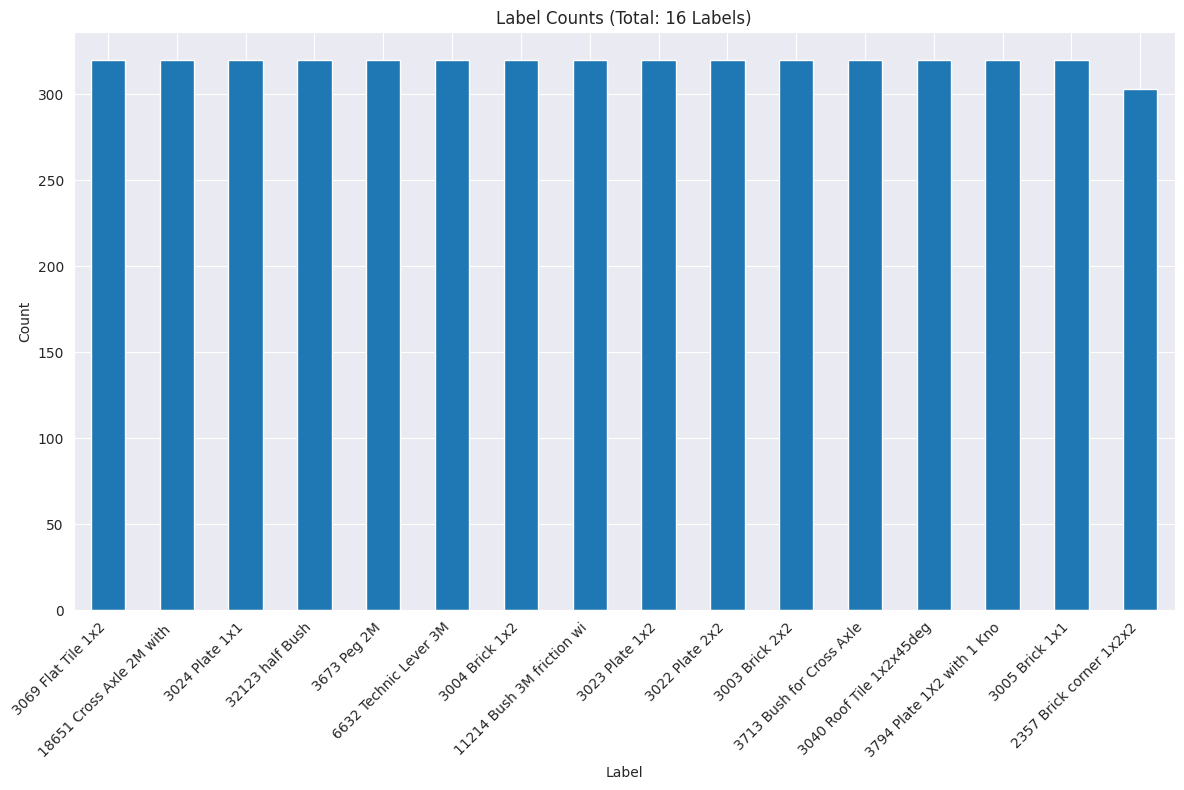

In [ ]:
plot_label_count(train_df, 'labels', class_count)

In [ ]:
train_df, classes, class_count = trim(train_df, max_samples, min_samples, 'labels')

DataFrame initially has 5103 samples with 16 classes
After trimming, the maximum samples per class is 300, and the minimum is 300
The trimmed DataFrame now has 4800 samples with 16 classes


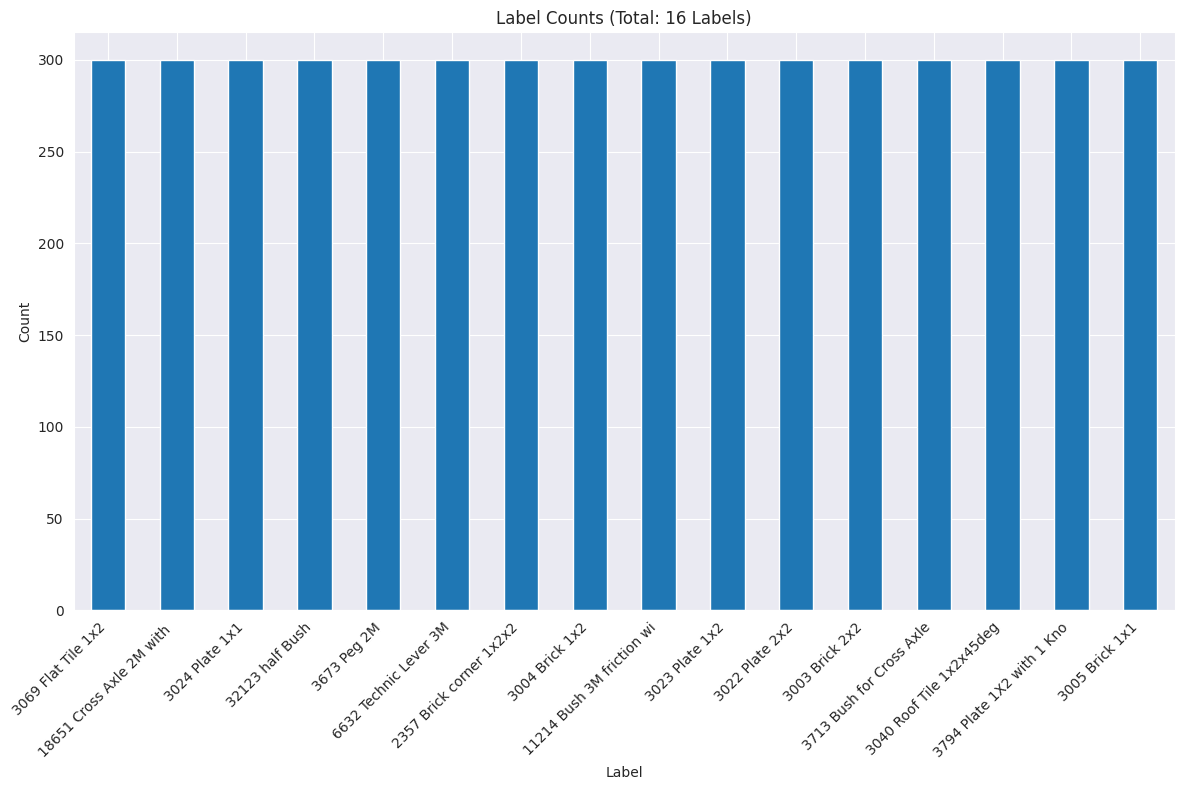

In [ ]:
plot_label_count(train_df, 'labels', class_count)


In [ ]:
def make_gens(batch_size, ycol, train_df, test_df, valid_df, img_size):
    trgen=ImageDataGenerator(horizontal_flip=True)
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
    test_steps=int(length/test_batch_size)
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_steps

In [ ]:
img_size=(128,128) # use smaller image size to reduce training time but may reduce F1 score
batch_size=32
ycol='labels'
train_gen, test_gen, valid_gen, test_steps= make_gens(batch_size, ycol, train_df, test_df, valid_df, img_size)

Found 4800 validated image filenames belonging to 16 classes.
Found 638 validated image filenames belonging to 16 classes.
Found 638 validated image filenames belonging to 16 classes.
test batch size:  58   test steps:  11  number of classes :  16


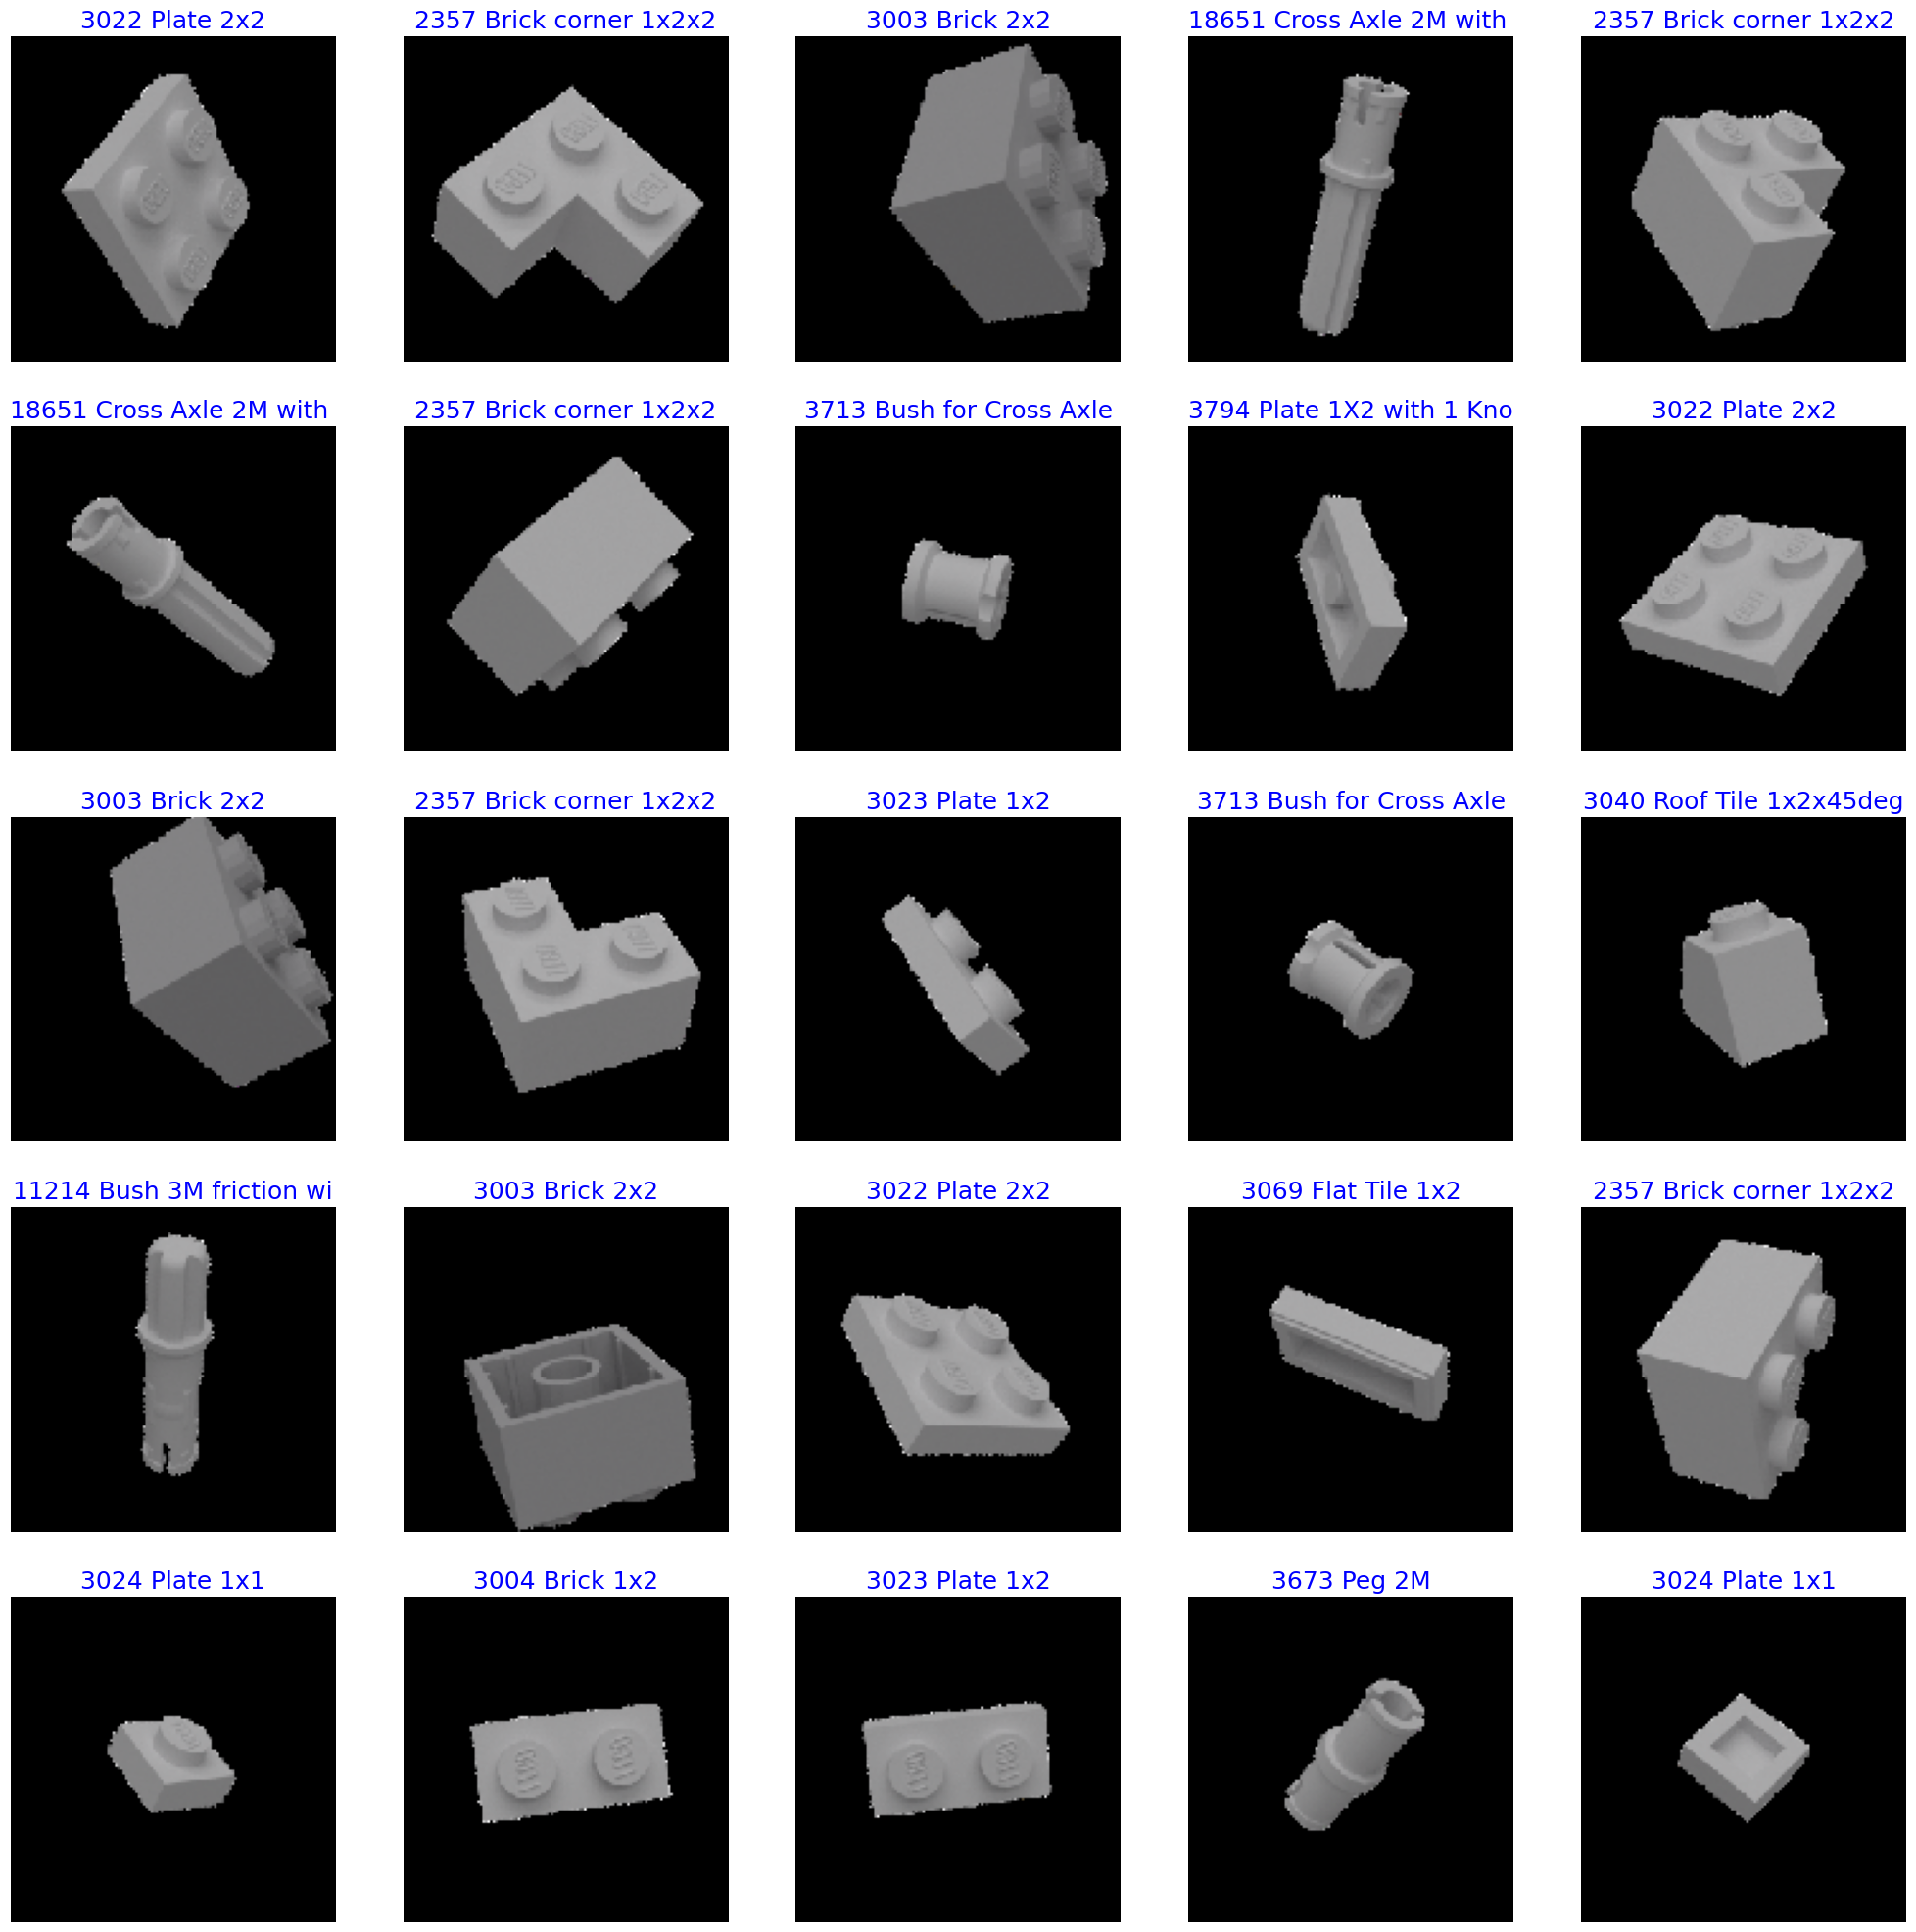

In [ ]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(25, 25))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i] /255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()

show_image_samples(train_gen )

In [ ]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val


In [ ]:
def make_model(img_size, lr, mod_num=7):
    img_shape = (img_size[0], img_size[1], 3)

    models = {
        0: tf.keras.applications.EfficientNetB0,
        3: tf.keras.applications.EfficientNetB3,
        5: tf.keras.applications.EfficientNetB5,
        7: tf.keras.applications.EfficientNetB7
    }

    base_model = models.get(mod_num, tf.keras.applications.EfficientNetB7)(
        include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

    msg = f'Created EfficientNet B{mod_num} model'

    base_model.trainable = True

    bn_momentum = 0.99
    bn_epsilon = 0.001
    dropout_rate = 0.

    x = base_model.output
    x = BatchNormalization(axis=-1, momentum=bn_momentum, epsilon=bn_epsilon)(x)
    x = Dropout(rate=dropout_rate, seed=123)(x)

    output = Dense(class_count, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy', f1_score])

    print_in_color(f'{msg} with initial learning rate set to {lr}')

    return model

lr = 0.001
model = make_model(img_size, lr)  # using B3 model by default

Created EfficientNet B7 model with initial learning rate set to 0.001



In [ ]:
def print_in_color(msg, color=(0, 255, 0)):  # 确保此函数实现彩色打印或按你的需求修改
    print(msg)

class LR_ASK(keras.callbacks.Callback):
    def __init__(self, epochs, ask_epoch, dwell=True, factor=0.4):
        super(LR_ASK, self).__init__()
        self.ask_epoch = ask_epoch
        self.epochs = epochs
        self.ask = True
        self.lowest_val_loss = np.inf
        self.lowest_train_loss = np.inf
        self.best_weights = None
        self.best_epoch = 1
        self.val_loss_list = []
        self.train_loss_list = []
        self.dwell = dwell
        self.factor = factor

    def get_loss_lists(self):
        return self.val_loss_list, self.train_loss_list

    def on_train_begin(self, logs=None):
        self.ask_epoch = max(1, self.ask_epoch)
        self.ask = self.ask_epoch < self.epochs

        if self.ask:
            msg = f'Training will proceed until epoch {self.ask_epoch}, then you will be asked to enter H to halt training or enter an integer for how many more epochs to run then be asked again'
            print_in_color(msg)
        else:
            msg = f'Training will proceed for {self.epochs} epochs'
            print_in_color(msg)

        if self.dwell:
            print_in_color('Learning rate will be automatically adjusted during training', color=(0, 255, 0))

        self.start_time = time.time()
        self.best_weights = self.model.get_weights()

    def on_train_end(self, logs=None):
        msg = f'Loading model with weights from epoch {self.best_epoch}'
        print_in_color(msg, color=(0, 255, 255))
        self.model.set_weights(self.best_weights)

        elapsed_time = time.time() - self.start_time
        hours, rem = divmod(elapsed_time, 3600)
        minutes, seconds = divmod(rem, 60)
        msg = f'Training elapsed time was {int(hours)} hours, {int(minutes)} minutes, {seconds:4.2f} seconds'
        print_in_color(msg)

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        train_loss = logs.get('loss')

        if epoch > 0:
            val_loss_improv = (self.lowest_val_loss - val_loss) / self.lowest_val_loss * 100
            self.val_loss_list.append(val_loss_improv)

            train_loss_improv = (self.lowest_train_loss - train_loss) / self.lowest_train_loss * 100
            self.train_loss_list.append(train_loss_improv)
        else:
            val_loss_improv = 0.0
            train_loss_improv = 0.0

        if val_loss < self.lowest_val_loss:
            self.lowest_val_loss = val_loss
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch + 1

            msg = f'\nValidation loss of {val_loss:7.4f} is {val_loss_improv:7.4f}% better, saving weights from epoch {self.best_epoch} as best'
            print_in_color(msg, color=(0, 255, 0))
        else:
            msg = f'\nValidation loss of {val_loss:7.4f} is {abs(val_loss_improv):7.4f}% worse than best of {self.lowest_val_loss:7.4f}, keeping weights from epoch {self.best_epoch}'
            print_in_color(msg, color=(255, 255, 0))

            if self.dwell:
                lr = float(keras.backend.get_value(self.model.optimizer.learning_rate))
                new_lr = lr * self.factor
                keras.backend.set_value(self.model.optimizer.learning_rate, new_lr)
                self.model.set_weights(self.best_weights)

                msg = f'Learning rate adjusted from {lr:8.6f} to {new_lr:8.6f}, weights set to best'
                print_in_color(msg)

        if train_loss < self.lowest_train_loss:
            self.lowest_train_loss = train_loss


        if train_loss < self.lowest_train_loss:
            self.lowest_train_loss = train_loss

        if self.ask and epoch + 1 == self.ask_epoch:
            msg = 'Press Enter to continue or enter a comment:'
            print_in_color(msg)
            comment = input().strip()
            if comment:
                print_in_color(f'User comment: {comment}')

            msg = '\nEnter H to halt training or an integer for number of additional epochs to run then ask again:'
            print_in_color(msg)
            answer = input().strip().lower()

            if answer in ['h', '0']:
                msg = f'You entered {answer}, halting training on epoch {epoch+1}'
                print_in_color(msg)
                self.model.stop_training = True
            else:
                self.ask_epoch += int(answer)

                if self.ask_epoch > self.epochs:
                    print(f'\nCannot train for {self.ask_epoch} epochs, maximum is {self.epochs}')
                else:
                    msg = f'You entered {answer}, training will continue to epoch {self.ask_epoch}'
                    print_in_color(msg)

                    if not self.dwell:
                        lr = float(keras.backend.get_value(self.model.optimizer.lr))
                        msg = f'Current learning rate is {lr:8.6f}, Enter to keep or enter a new learning rate:'
                        print_in_color(msg)
                        new_lr = input().strip()

                        if new_lr:
                            keras.backend.set_value(self.model.optimizer.lr, float(new_lr))
                            print_in_color(f'Learning rate changed to {new_lr}')
                        else:
                            print_in_color(f'Keeping learning rate at {lr:8.6f}')


In [ ]:
epochs=5
ask_epoch=5
ask=LR_ASK(epochs,  ask_epoch)
callbacks=[ask]


In [ ]:
history=model.fit(x=train_gen,   epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed for 5 epochs
Learning rate will be automatically adjusted during training
Epoch 1/5
150/150 [==============================] - ETA: 0s - loss: 0.7607 - accuracy: 0.7846 - f1_score: 0.7829
Validation loss of  0.5043 is  0.0000% better, saving weights from epoch 1 as best
150/150 [==============================] - 1120s 7s/step - loss: 0.7607 - accuracy: 0.7846 - f1_score: 0.7829 - val_loss: 0.5043 - val_accuracy: 0.8339 - val_f1_score: 0.8292
Epoch 2/5
150/150 [==============================] - ETA: 0s - loss: 0.1989 - accuracy: 0.9371 - f1_score: 0.9358
Validation loss of  0.1691 is 66.4731% better, saving weights from epoch 2 as best
150/150 [==============================] - 1007s 7s/step - loss: 0.1989 - accuracy: 0.9371 - f1_score: 0.9358 - val_loss: 0.1691 - val_accuracy: 0.9342 - val_f1_score: 0.9283
Epoch 3/5
150/150 [==============================] - ETA: 0s - loss: 0.1123 - accuracy: 0.9648 - f1_score: 0.9650
Validation loss of  0.1318 is 22.0453% better,

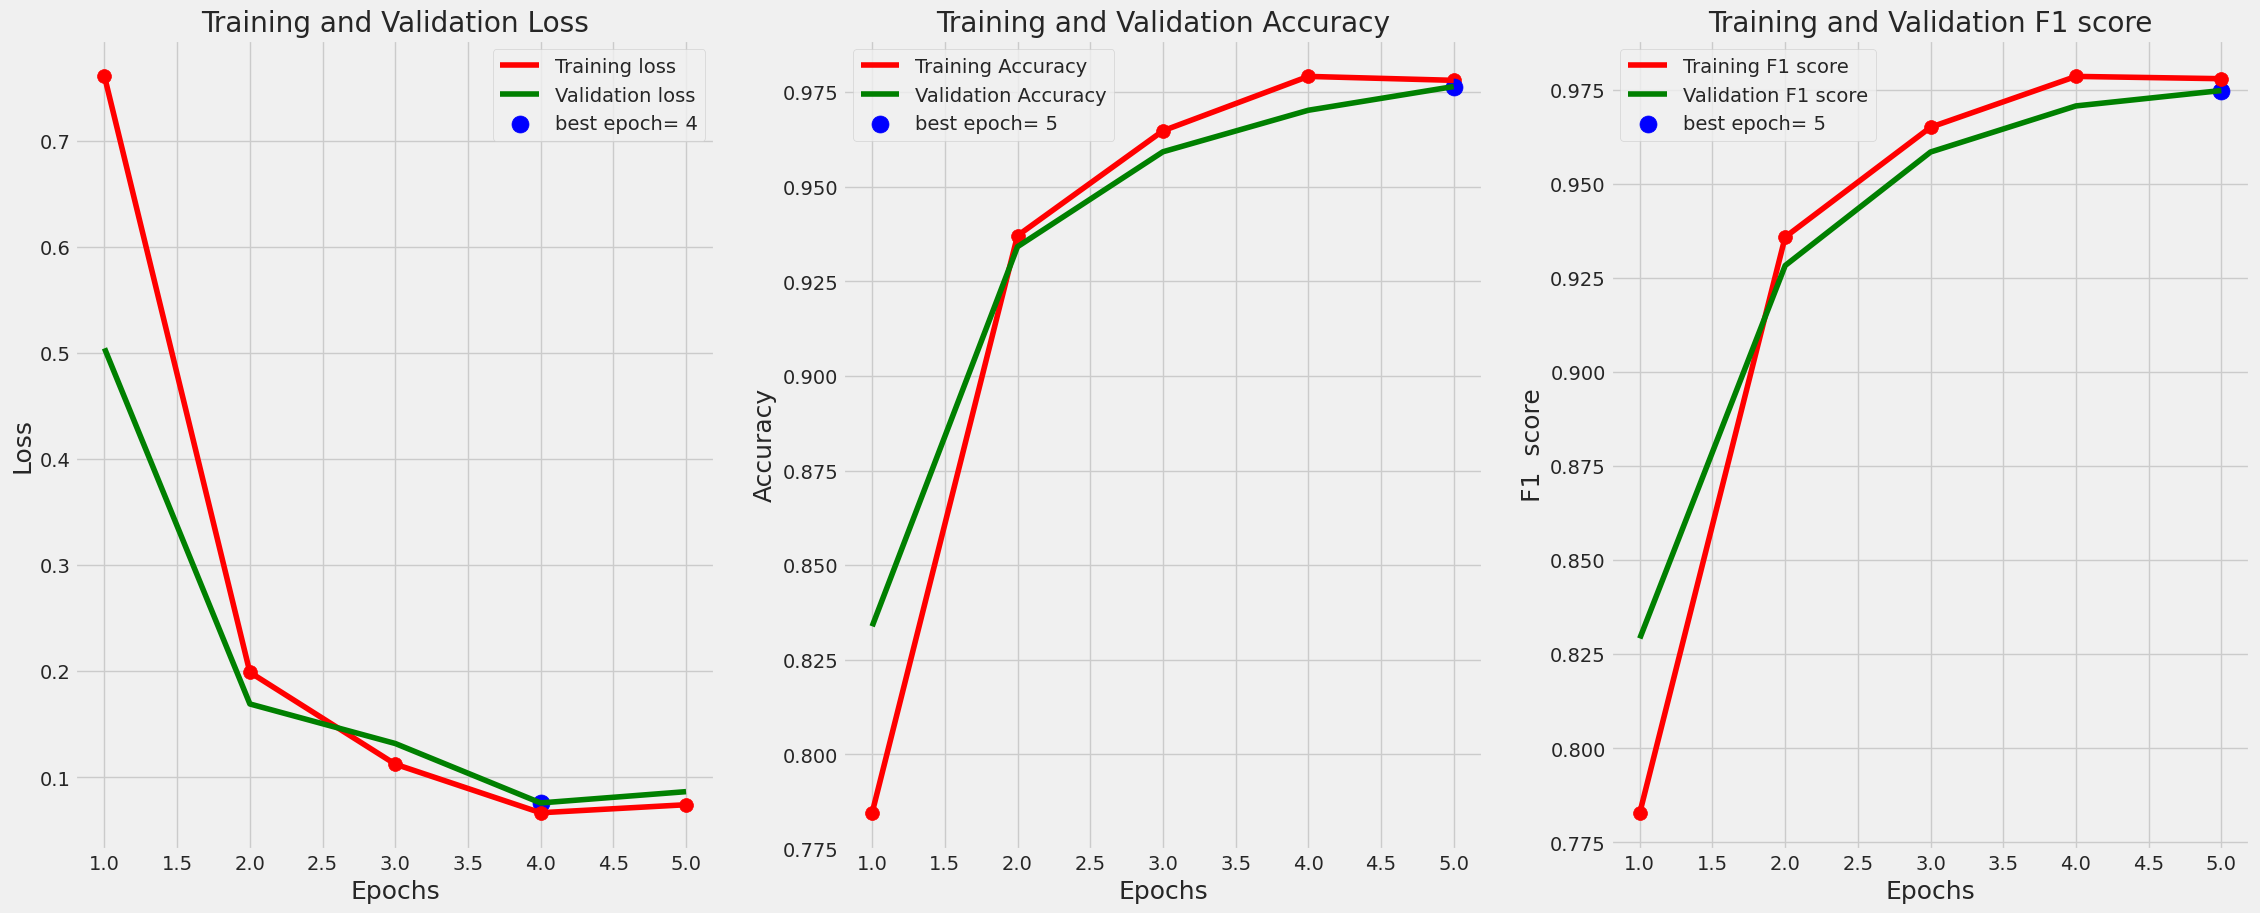

In [ ]:
def tr_plot(tr_data):
    start_epoch=0
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    tf1=tr_data.history['f1_score']
    vf1=tr_data.history['val_f1_score']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=3, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    axes[2].plot (Epochs,tf1,'r',label= 'Training F1 score')
    axes[2].plot (Epochs,vf1,'g',label= 'Validation F1 score')
    index_tf1=np.argmax(tf1)#  this is the epoch with the highest training F1 score
    tf1max=tf1[index_tf1]
    index_vf1=np.argmax(vf1)# thisiis the epoch with the highest validation F1 score
    vf1max=vf1[index_vf1]
    axes[2].scatter(index_vf1+1 +start_epoch,vf1max, s=150, c= 'blue', label=vc_label)
    axes[2].scatter(Epochs, tf1, s=100, c='red')
    axes[2].set_title('Training and Validation F1 score')
    axes[2].set_xlabel('Epochs', fontsize=18)
    axes[2].set_ylabel('F1  score', fontsize=18)
    axes[2].legend()

    plt.tight_layout
    plt.show()
    return

tr_plot(history)

11/11 [==============================] - 31s 3s/step
y_pred dtype: int64
y_true dtype: int64
there were 19 errors in 638 tests for an accuracy of  97.02


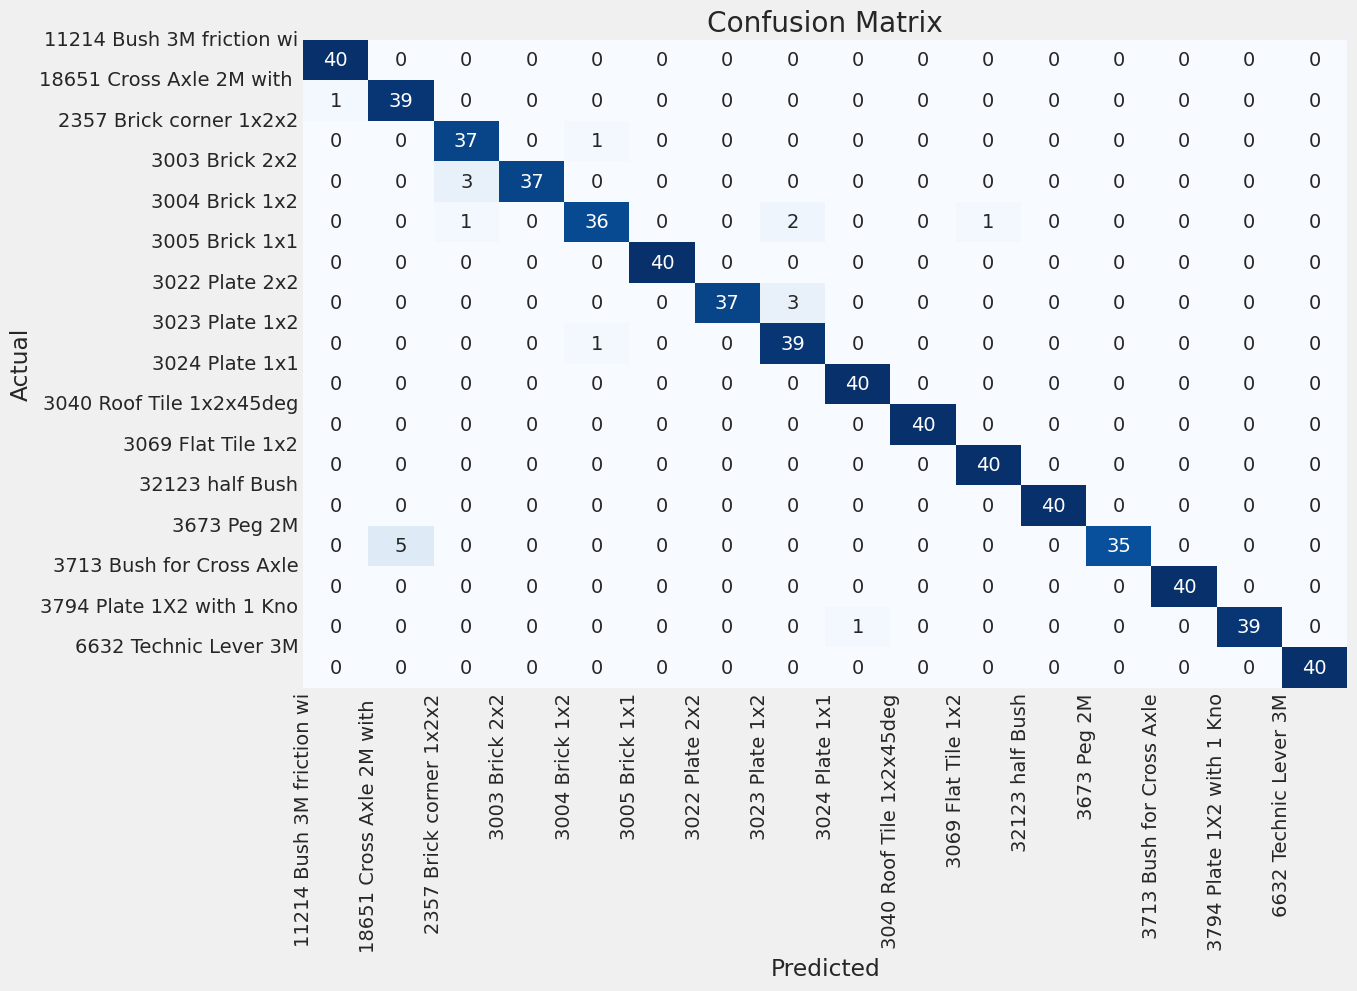

Classification Report:
----------------------
                            precision    recall  f1-score   support

11214 Bush 3M friction wi     0.9756    1.0000    0.9877        40
18651 Cross Axle 2M with      0.8864    0.9750    0.9286        40
  2357 Brick corner 1x2x2     0.9024    0.9737    0.9367        38
           3003 Brick 2x2     1.0000    0.9250    0.9610        40
           3004 Brick 1x2     0.9474    0.9000    0.9231        40
           3005 Brick 1x1     1.0000    1.0000    1.0000        40
           3022 Plate 2x2     1.0000    0.9250    0.9610        40
           3023 Plate 1x2     0.8864    0.9750    0.9286        40
           3024 Plate 1x1     0.9756    1.0000    0.9877        40
 3040 Roof Tile 1x2x45deg     1.0000    1.0000    1.0000        40
       3069 Flat Tile 1x2     0.9756    1.0000    0.9877        40
          32123 half Bush     1.0000    1.0000    1.0000        40
              3673 Peg 2M     1.0000    0.8750    0.9333        40
 3713 Bush for

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def predictor(test_gen):
    y_pred = []
    error_list = []
    error_pred_list = []
    y_true = test_gen.labels
    classes = list(test_gen.class_indices.keys())
    class_count = len(classes)
    errors = 0
    preds = model.predict(test_gen, verbose=1)
    tests = len(preds)

    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        true_index = test_gen.labels[i]

        if pred_index != true_index:
            errors += 1
            file = test_gen.filenames[i]
            error_list.append(file)
            error_class = classes[pred_index]
            error_pred_list.append(error_class)

        y_pred.append(pred_index)

    y_pred = np.array(y_pred, dtype=np.int64)
    y_true = np.array(y_true, dtype=np.int64)  # 确保 y_true 也是 int64 类型

    # 输出类型调试信息
    print("y_pred dtype:", y_pred.dtype)
    print("y_true dtype:", y_true.dtype)

    f1score = f1_score(y_true, y_pred, average='macro') * 100

    acc = (1 - errors / tests) * 100
    msg = f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}'
    print_in_color(msg, (0, 255, 255))  # cyan foreground

    if class_count <= 30:
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count), classes, rotation=90)
        plt.yticks(np.arange(class_count), classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)
    print("Classification Report:\n----------------------\n", clr)

    return errors, tests, error_list, error_pred_list, f1score

# 调用 predictor 函数
errors, tests, error_list, error_pred_list, f1score = predictor(test_gen)

In [ ]:
def print_in_color(msg, color_code):
    print(f"\033[1;{color_code}m{msg}\033[0m")

def print_errors(error_list, error_pred_list):
    if len(error_list) == 0:
        print_in_color('There were no errors in predicting the test set', '32')  # Green for no errors
    else:
        if len(error_list) > 50:
            print_in_color('There were over 50 misclassifications, the error list will not be printed', '31')  # Red for warning
        else:
            print('Below is a list of test files that were misclassified and their incorrect predictions:\n')
            print('{0:^30s}{1:^30s}'.format('Test File', 'Predicted as'))
            print('-' * 60)
            for file_path, predicted_class in zip(error_list, error_pred_list):
                # Extracting the file name from the file path safely
                file_name = file_path.split('/')[-1]  # Assumes UNIX-style paths
                display_string = f"{file_name:^30s}{predicted_class:^30s}"
                print(display_string)

# Example usage:
# Suppose error_list and error_pred_list are defined somewhere else in your script as shown previously
print_errors(error_list, error_pred_list)

Below is a list of test files that were misclassified and their incorrect predictions:

          Test File                    Predicted as         
------------------------------------------------------------
           0279.png             18651 Cross Axle 2M with    
           0088.png             18651 Cross Axle 2M with    
           0280.png             18651 Cross Axle 2M with    
           0281.png              2357 Brick corner 1x2x2    
           0085.png                   3023 Plate 1x2        
           0302.png                 3069 Flat Tile 1x2      
           0095.png             18651 Cross Axle 2M with    
    201706161606-0111.png             3024 Plate 1x1        
           0124.png                   3023 Plate 1x2        
           0298.png             18651 Cross Axle 2M with    
    201706171106-0321.png       11214 Bush 3M friction wi   
    201706161906-0281.png             3023 Plate 1x2        
           0217.png              2357 Brick corner 1x2x2  

The images below show misclassified test images on left and an example of an image in the misclassified class


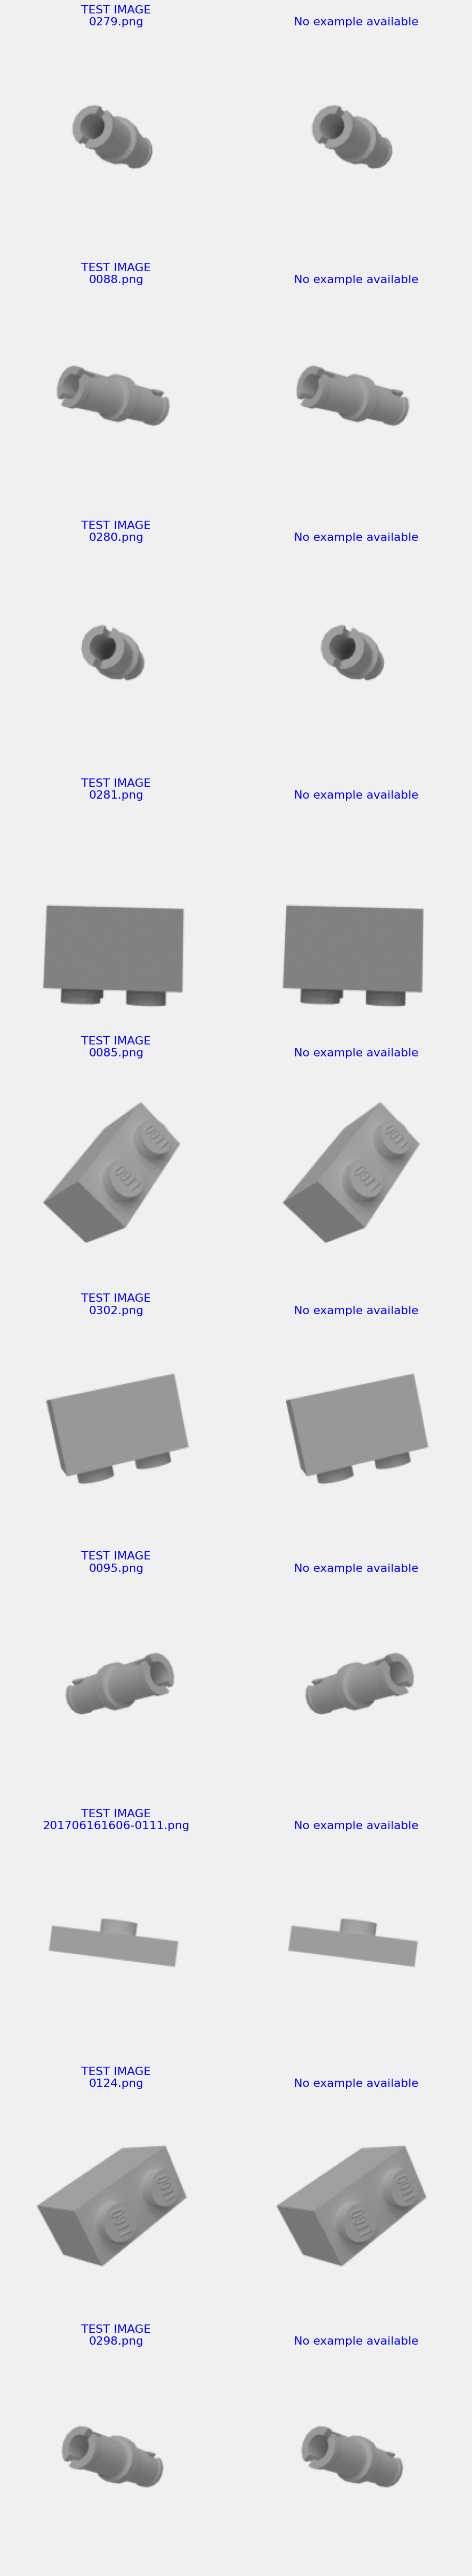

In [ ]:
import matplotlib.pyplot as plt
import os

def show_misclassification(error_list, error_pred_list, test_gen):
    if not error_list:
        print_in_color('There were no errors in predicting the test images')
        return

    # Display up to 10 misclassified images
    length = min(len(error_list), 10)
    msg = 'The images below show misclassified test images on left and an example of an image in the misclassified class'
    print_in_color(msg, '31')  # Assume 'print_in_color' is defined as before

    plt.figure(figsize=(10, length * 5))

    # Build a map from class to example file path for quick lookup
    class_to_example_path = {}
    for fpath in test_gen.filenames:
        class_name = os.path.dirname(fpath)
        if class_name not in class_to_example_path:
            class_to_example_path[class_name] = fpath

    for i in range(length):
        fpath = error_list[i]
        test_img = plt.imread(fpath)
        pred_class = error_pred_list[i]

        # Use the prebuilt map to find an example image from the predicted class
        pred_img_path = class_to_example_path.get(pred_class)
        pred_img = plt.imread(pred_img_path) if pred_img_path else None

        for j in range(2):
            plt.subplot(length, 2, i * 2 + j + 1)
            plt.axis('off')
            if j == 0:
                plt.imshow(test_img)
                title = 'TEST IMAGE\n' + os.path.basename(fpath)
                plt.title(title, color='blue', fontsize=16)
            else:
                plt.imshow(pred_img if pred_img is not None else test_img)  # Show test_img if no pred_img found
                title = 'PREDICTED CLASS EXAMPLE\n' + os.path.basename(pred_img_path) if pred_img_path else 'No example available'
                plt.title(title, color='blue', fontsize=16)

    plt.tight_layout()
    plt.show()

# Assume error_list, error_pred_list, and test_gen are defined and passed correctly
show_misclassification(error_list, error_pred_list, test_gen)

In [ ]:
def save_model(subject, classes, img_size, f1score, working_dir):
    name=subject + '-' + str(len(classes)) + '-(' + str(img_size[0]) + ' X ' + str(img_size[1]) + ')'
    save_id=f'{name}-{f1score:5.2f}.h5'
    model_save_loc=os.path.join(working_dir, save_id)
    model.save(model_save_loc)
    msg= f'model was saved as {model_save_loc}'
    print_in_color(msg, (0,255,255)) # cyan foreground

In [ ]:
working_dir=r'LGCS_model'
subject='legos'
save_model(subject, classes, img_size, f1score, working_dir)

[1;(0, 255, 255)mmodel was saved as LGCS_model/legos-16-(128 X 128)-97.02.h5
